In [6]:
pip install scikit-learn==0.23.1


139.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 542.4 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [9028 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX" and platform_python_implementation == "CPython"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX" and platform_python_implementation != "CPython"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system =

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
from common_variables import *

/Users/tahaatiq/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
df = pd.read_csv(test_time_series_path, dayfirst = True, index_col=['Date'], parse_dates=['Date'], usecols=['Date','HLAvg','MA','Returns'])

/var/folders/wy/tcd919h11l33h541fh7w9dd80000gn/T/ipykernel_43783/1109942956.py:1: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv(test_time_series_path, dayfirst = True, index_col=['Date'], parse_dates=['Date'], usecols=['Date','HLAvg','MA','Returns'])


In [6]:
scaler = joblib.load(scaler_path)
scaler.clip = False  # Manually set the clip attribute
df['Scaled'] = scaler.transform(df[['Returns']].values)


/Library/Python/3.9/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
model = load_model(model_path)

In [8]:
scaled = df['Scaled'].values
X = []
len_scaled = len(scaled)
for i in range(window_size, len_scaled):
    X.append(scaled[i-window_size:i])
X = np.asarray(X)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y_true = scaled[-X.shape[0]:]
print(f"X {X.shape}, y_real {y_true.shape}")

X (262144, 256, 1), y_real (262144,)


In [9]:
mse = model.evaluate(X, y_true, verbose=1)
print("Mean Squared Error:", mse)

8192/8192 [==============================] - 110s 13ms/step - loss: 2.1140e-06
Mean Squared Error: 2.113994469254976e-06


In [10]:
y_pred = model.predict(X)
y_pred.shape

8192/8192 [==============================] - 109s 13ms/step


(262144, 1)

In [11]:
df['Pred_Scaled'] = np.pad(y_pred.reshape(y_pred.shape[0]), (window_size, 0), mode='constant', constant_values=np.nan)
df['Pred_Returns'] = scaler.inverse_transform(df[['Pred_Scaled']].values)
#df['Pred_MA'] = df["MA"].mul(1 + df['Pred_Returns'].shift(-1)).shift(1) # Arithmetic Returns
df['Pred_MA'] = df['MA'].mul(np.exp(df['Pred_Returns'].shift(-1))).shift(1) # Log Returns
df = df[window_size:]
df

,HLAvg,MA,Returns,Scaled,Pred_Scaled,Pred_Returns,Pred_MA
Date,,,,,,,
2023-03-22 05:50:00,1.223390,1.223566,0.000024,0.613841,0.615696,0.000034,1.223579
2023-03-22 05:51:00,1.223160,1.223562,-0.000004,0.608862,0.610716,0.000007,1.223574
2023-03-22 05:52:00,1.223040,1.223532,-0.000025,0.605008,0.605405,-0.000022,1.223535
2023-03-22 05:53:00,1.223005,1.223494,-0.000031,0.603776,0.603981,-0.000030,1.223495
2023-03-22 05:54:00,1.223010,1.223459,-0.000029,0.604204,0.603855,-0.000031,1.223456
...,...,...,...,...,...,...,...
2023-12-01 21:55:00,1.270935,1.270822,0.000001,0.609762,0.609083,-0.000002,1.270817
2023-12-01 21:56:00,1.271035,1.270829,0.000006,0.610587,0.609225,-0.000002,1.270820
2023-12-01 21:57:00,1.271040,1.270834,0.000004,0.610226,0.610329,0.000004,1.270835


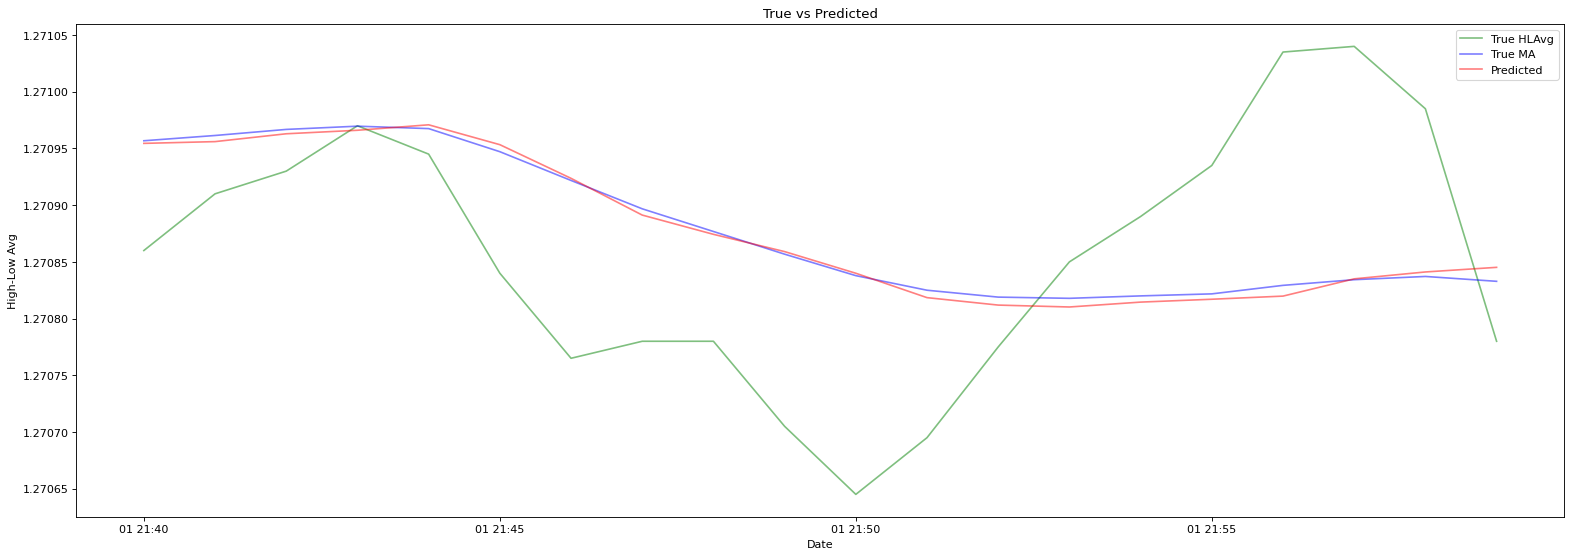

In [12]:
plt.figure(figsize=(24, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['HLAvg'][-20:], color = 'green', label = 'True HLAvg', alpha=0.5)
plt.plot(df['MA'][-20:], color = 'blue', label = 'True MA', alpha=0.5)
plt.plot(df['Pred_MA'][-20:], color = 'red', label = 'Predicted', alpha=0.5)
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('High-Low Avg')
plt.legend()
plt.show()